Entry: /usr/lib/python3/dist-packages/ipykernel_launcher.py
System argument(s): 3
Start of "/usr/lib/python3/dist-packages/ipykernel_launcher.py"
Processing ./testdata/3.png ...
(256, 256, 3)
Kernel execution time: 0.0058634281158447266 s


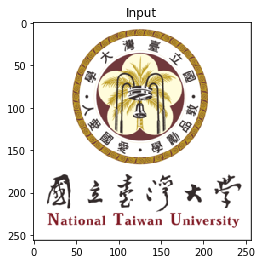

CPU rum time: 1.8615121841430664 sec


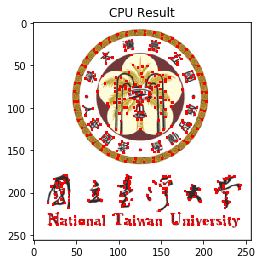

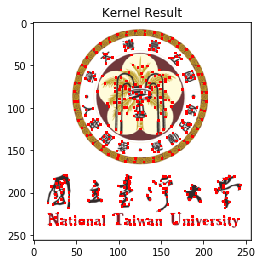

Exit process


In [31]:
from __future__ import print_function

import sys
import numpy as np
from time import time
from HCD import Harris_corner_detector
sys.path.append('/home/xilinx')
from pynq import Overlay
from pynq import allocate
import cv2
from matplotlib import pyplot as plt

if __name__ == "__main__":
    threshold = 100.0
    image_path = './host_test/3.png'
    max_width = 1920
    max_height = 1080
    print("Entry:", sys.argv[0])
    print("System argument(s):", len(sys.argv))
    print("Start of \"" + sys.argv[0] + "\"")
    
    print('Processing %s ...'%image_path)
    img = cv2.imread(image_path)
    img2 = img
    print(img.shape)
    nbytes = img.shape[0] * img.shape[1] * 4

    #kernel 
    ol = Overlay("./opt1/HCD.bit")
    ipHCD = ol.HCD_0
    ipDMAIn = ol.axi_dma_0
    ipDMAOut = ipDMAIn
    inBuffer0 = allocate(shape=(max_width * max_height,), dtype=np.int32)
    outBuffer0 = allocate(shape=(max_width * max_height,), dtype=np.int32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            inBuffer0[i*img.shape[1] + j] = int(img[i][j][0] + (img[i][j][1] << 8) + (img[i][j][2] << 16))
    timeKernelStart = time()
    ipHCD.write(0x10, img.shape[0])
    ipHCD.write(0x18, img.shape[1])
    ipHCD.write(0x00, 0x01)
    ipDMAIn.sendchannel.transfer(inBuffer0, nbytes=nbytes)
    ipDMAOut.recvchannel.transfer(outBuffer0, nbytes=nbytes)
    ipDMAIn.sendchannel.wait()
    ipDMAOut.recvchannel.wait()
    timeKernelEnd = time()
    print("Kernel execution time: " + str(timeKernelEnd - timeKernelStart) + " s")
    
    #print input
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Input')
    plt.show()
    
    #CPU
    cpu_start = time()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    HCD = Harris_corner_detector(threshold)
    response = HCD.detect_harris_corners(img_gray)
    result = HCD.post_processing(response)
    cpu_end = time()
    print("CPU rum time:", (cpu_end - cpu_start), "sec")
    
    for res in result:
        if res[0] < img.shape[0] - 1:
            if res[1] < img.shape[1] - 1:
                img[res[0]+1, res[1]+1] = [0, 0, 255]
            if res[1] > 0:
                img[res[0]+1, res[1]-1] = [0, 0, 255]
            img[res[0]+1, res[1]] = [0, 0, 255]
        if res[0] > 0:
            if res[1] < img.shape[1] - 1:
                img[res[0]-1, res[1]+1] = [0, 0, 255]
            if res[1] > 0:
                img[res[0]-1, res[1]-1] = [0, 0, 255]
            img[res[0]-1, res[1]] = [0, 0, 255]
        if res[1] < img.shape[1] - 1:
            img[res[0], res[1]+1] = [0, 0, 255]
        if res[1] > 0:
            img[res[0], res[1]-1] = [0, 0, 255]
        img[res[0], res[1]] = [0, 0, 255]
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('CPU Result')
    plt.show()
    
    #print kernel result
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(outBuffer0[i*img.shape[1] + j] == 1):
                img2[i, j] = [0, 0, 255]
    image_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Kernel Result')
    plt.show()
      
    
    print("============================")
    print("Exit process")


